# IMPORTAR AS BIBLIOTECAS

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
plt.style.use("ggplot")
%matplotlib inline
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from keras import regularizers
from keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.keras.layers import Dropout, Input
from tensorflow.python.keras.layers import MaxPooling1D
from keras.utils import np_utils
from tensorflow.keras.layers import GlobalMaxPooling2D, GlobalMaxPooling1D, GlobalMaxPooling3D
import tensorflow as tf
from tensorflow.keras.metrics import SpecificityAtSensitivity, SensitivityAtSpecificity, BinaryAccuracy, Accuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam as Adam
import json

import keras.backend.tensorflow_backend as K
from sklearn.ensemble import RandomForestClassifier
import warnings
from keras.preprocessing import image
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings("ignore")
import xgboost as xgb 
from sklearn.externals import joblib
import time

# PROCESSAMENTO DE DADOS

# CARREGAR DADOS PRÉ-PROCESSADOS

In [ ]:
df_dados=pd.read_csv('C:/Users/Bernardo/TCC/codigos/df_dados.csv')
malig=np.ones(len(df_dados),dtype=int)
malig[np.where(df_dados['tirads'].values=='2')]=0
malig[np.where(df_dados['tirads'].values=='3')]=0
df_dados['malig']=malig   
df_dados.head()



# TRANSFORMAR AS IMAGENS EM IMAGENS DE 3 CANAIS

In [ ]:
gray_three=[]
for i in range (452):
    image = cv2.imread('C:/Users/Bernardo/TCC/imagens_redondas/'+str(i)+'.png')
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_three1 = (cv2.merge([gray,gray,gray]))
    gray_three.append(gray_three1)


In [ ]:
np.shape(gray_three)

# REDIMENSIONAR AS IMAGENS


# 224 x 224 e 288 x 438

In [ ]:
nimg=len(gray_three)
nx=224#np.shape(gray_three)[1] #dimensão x
ny=224#np.shape(gray_three)[2] #dimensão y

X=np.zeros(((nimg,nx,ny,3)))
for id_ in range (len(gray_three)):
    x_img = gray_three[id_]
    x_img[np.where(x_img==255)]=0   #255 deixa o fundo branco e 0 deixa o fundo preto
    x_img = resize(x_img, (nx, ny,3), mode = 'constant', preserve_range = True)    
    X[id_,:,:]=x_img/255

#exemplo de imagem
plt.imshow(X[0,:,:],cmap='Greys')
plt.grid(False)

In [ ]:
Y=df_dados['malig'].values


In [ ]:
print(str(len(np.where(Y==0)[0])) + ' casos benignos')
print(str(len(np.where(Y==1)[0])) + ' casos malignos')
print(str(len(np.where(Y==1)[0])+len(np.where(Y==0)[0]))+' CASOS TOTAIS')

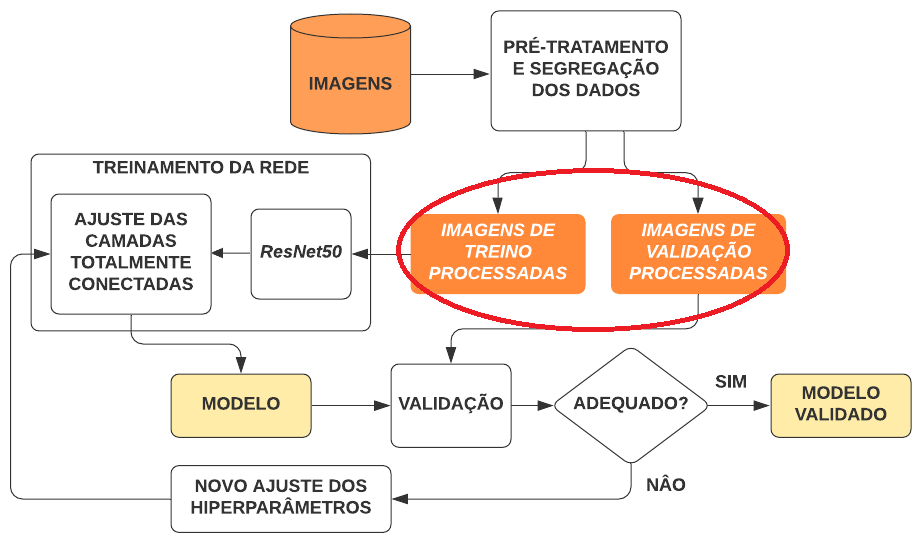

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2, random_state=42)

# PESOS PARA CADA CLASSE

In [ ]:
weights=class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

# DECLARAR E CRIAR A REDE 

### <span style="color:RED"> O QUE É UMA REDE PRÉ-TREINADA? </span>


### KERAS: https://keras.io/api/applications/

In [ ]:
base_model = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=(nx,ny,3))
base_model.trainable = False

######################

conf = json.loads(base_model.to_json())
for l in conf['config']['layers']:
    if l['class_name'] == 'BatchNormalization':
        l['config']['momentum'] = 0.9
        l['config']['trainable']= True

m = base_model.from_config(conf['config'])
for l in base_model.layers:
    m.get_layer(l.name).set_weights(l.get_weights())

base_model = m

##################
model = Sequential()
tf.random.set_seed(2)
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.4)) 
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.4)) 
model.add(Dense(1, activation='sigmoid'))  

epochs = 100
adam = Adam(lr=0.0001)


#############################
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()




# 1. CAMADA DE POOLING 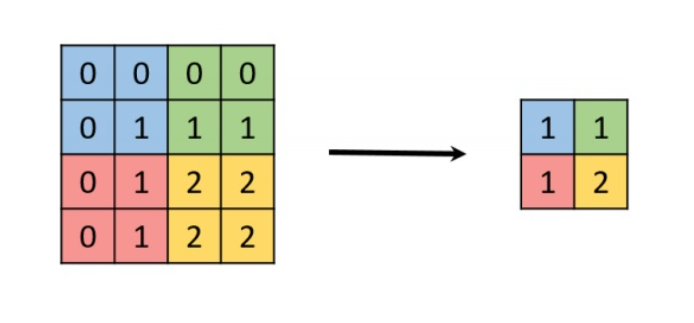

# 2. BATCH NORMALIZATION

# 3. DROPOUT

###  - TREINANDO DIFERENTES REDES, E SE ADAPTARÃO A DIFERENTES MANEIRAS 

### - DIMINUI O OVERFITTING 

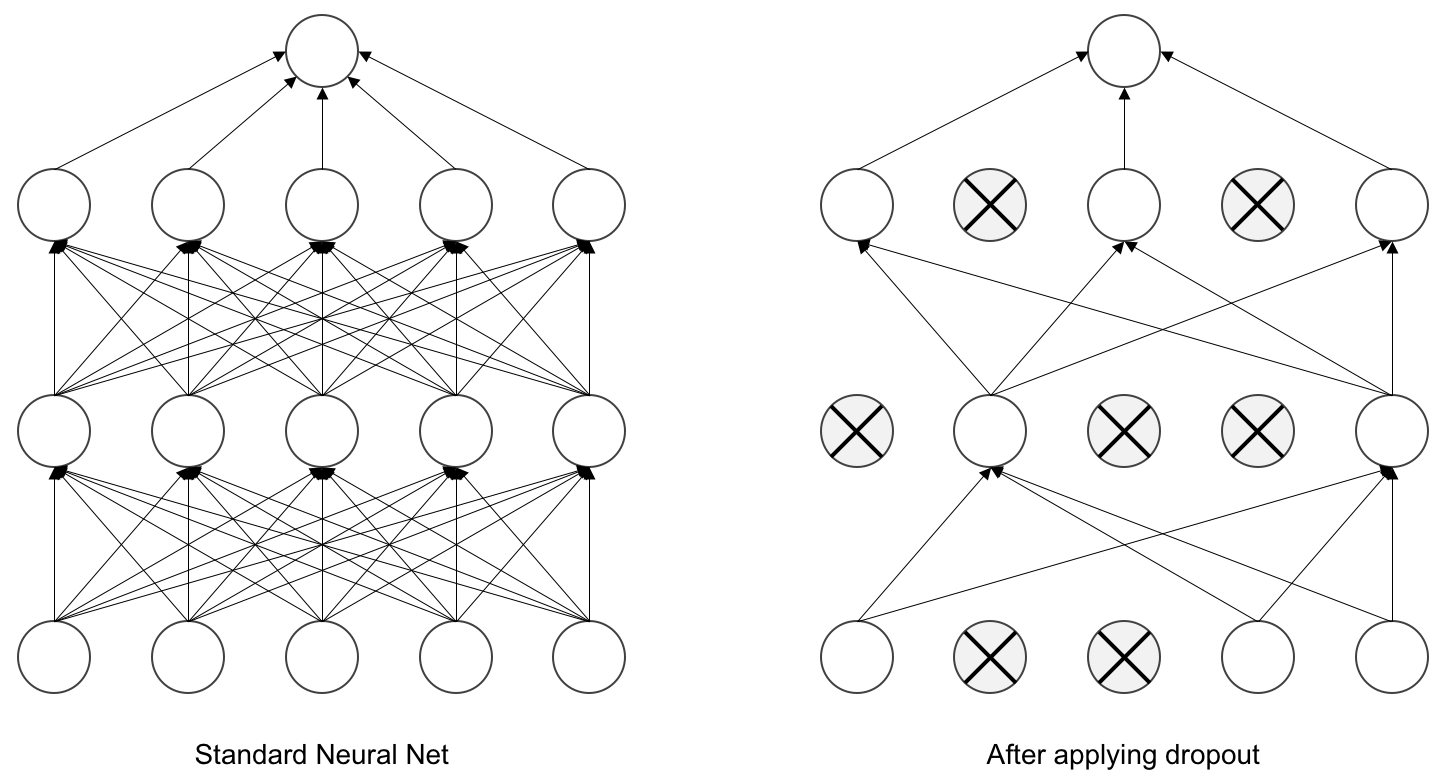

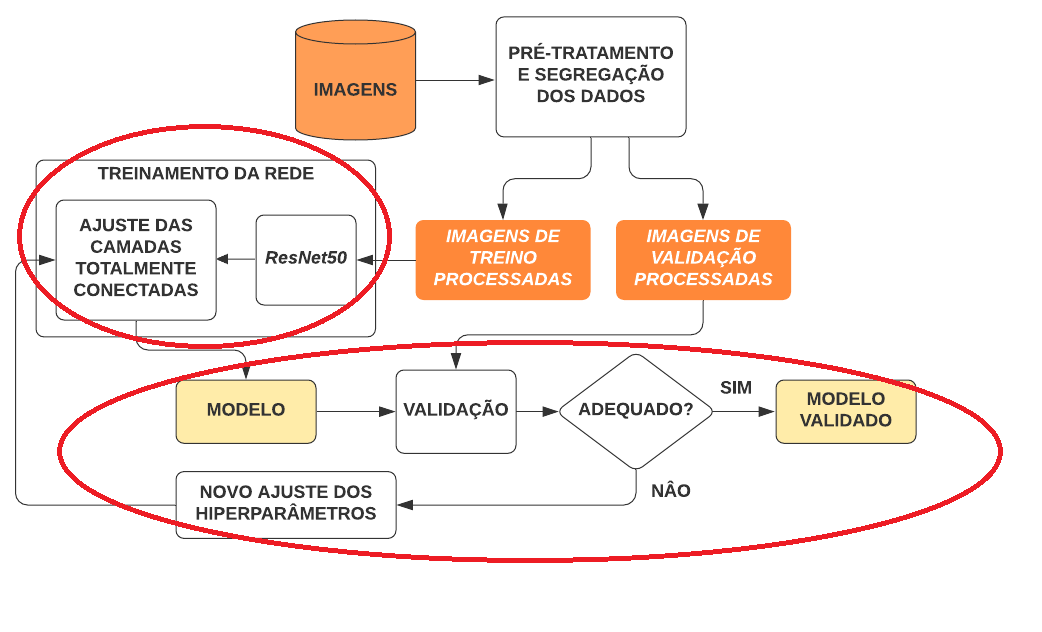

In [ ]:
rede=model.fit(X_train, y_train, epochs=epochs, class_weight= {0:weights[0], 1:weights[1]}, validation_data=(X_valid, y_valid), batch_size=10)

# MÉTRICAS UTILIZADAS

<ol>
<li> ACURÁCIA </li>
<li> SENSIBILIDADE </li>
<li> ESPECIFICIDADE</li>
</ol>


In [ ]:
Y_pred = model.predict(X_valid)
y_pred = np.round(Y_pred)
cmat=confusion_matrix(y_valid,y_pred,labels=[0,1])
cm_df = pd.DataFrame(cmat)                      
sns.heatmap(cm_df, annot=True,cmap='Blues',fmt="d")
plt.title('Teste')
print('ACC Teste (calc):'+str(np.sum(np.diag(cmat))*100/np.sum(cmat)))
print('ACC Teste (calc):'+str(np.sum(np.diag(cmat))*100/np.sum(cmat))+'%')
print('Sensibilidade: ' + str(cm_df.iloc[1][1]/(cm_df.iloc[0][1]+cm_df.iloc[1][1])*100)+'%')
print('Especificidade: ' + str(cm_df.iloc[0][0]/(cm_df.iloc[1][0]+cm_df.iloc[0][0])*100) + '%')

# MATRIZ DE CONFUSÃO (EXEMPLO)

# RESULTADOS OBTIDOS

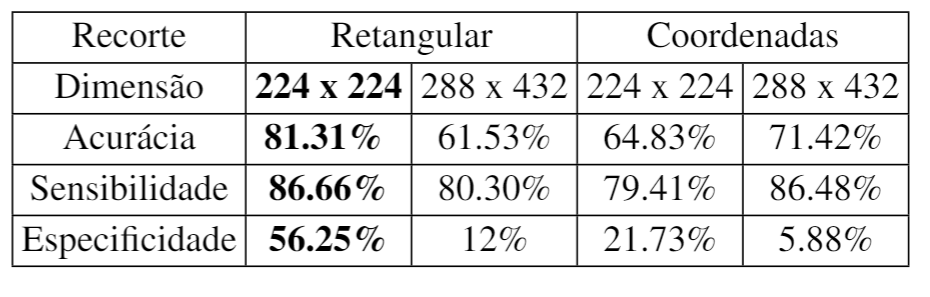

# RESULTADOS NA LITERATURA

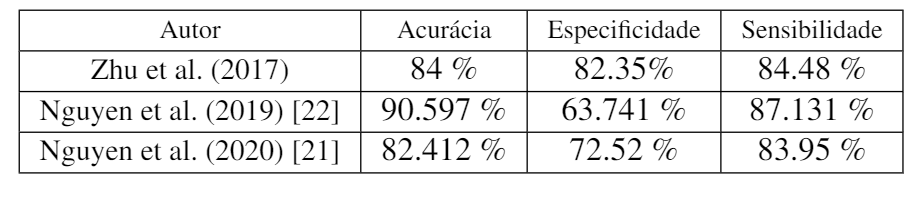